In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import math
import folium
import warnings
import sklearn.cluster as  skc
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)# arry 数字 不用科学计数法

# 公用变量
hour_str=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

In [2]:
##########################  公用函数    ################

#计算聚类的轮廓系数
from sklearn.metrics import silhouette_score
def Silhouette_ALL(data_Array,n):                                            
    estimator = skc.KMeans(n_clusters = n)#构造聚类器
    estimator.fit(data_Array)
    label = estimator.labels_
    return silhouette_score(data_Array, label) 

#找出凸集
def is_convex(temp,n):
    lat,lon = temp['lat_plot'][n],temp['lon_plot'][n]
    temp1 = temp[temp['lat_plot']>lat]
    temp2 = temp[temp['lat_plot']<lat]
    temp3 = temp[temp['lon_plot']>lon]
    temp4 = temp[temp['lon_plot']<lon]
    if len(temp1)*len(temp2)*len(temp3)*len(temp4) == 0:
        return True
    elif sum(temp1['lon_plot']>lon)*sum(temp1['lon_plot']<lon) == 0:
        return True
    elif sum(temp2['lon_plot']>lon)*sum(temp2['lon_plot']<lon) == 0:
        return True
    elif sum(temp3['lat_plot']<lat)*sum(temp3['lat_plot']>lat) == 0:
        return True
    elif sum(temp4['lat_plot']<lat)*sum(temp4['lat_plot']>lat) == 0:
        return True
    else:
        return False

In [ ]:

#******************************** 【  天气因素的影响  (可独立运行)  】 *****************************************


In [3]:
##### 0. 数据准备
work_per_hour =  pd.read_csv("C:/Users/83621/citibike1/work_per_hour.csv",index_col=0)
rest_per_hour =  pd.read_csv("C:/Users/83621/citibike1/rest_per_hour.csv",index_col=0)

##### 1. 决策树 特征重要性分析
from sklearn import tree
from sklearn.tree import  DecisionTreeRegressor

def cart_tree(weather_work,hour,features,md):
    if hour != '1day':
        weather_work = weather_work[weather_work['hour']== hour]
    weather_work = weather_work[features]
    dataset = weather_work.values
    data,lable = dataset[:,:-1],dataset[:,-1]
    model = DecisionTreeRegressor(max_depth=md)
    model.fit(data,lable)
    print(str(hour)+" 深度"+str(md)+" 拟合度" + str(round(model.score(data, lable),5))+" 重要度" +str(model.feature_importances_))
    return model
#-- 1.1 -- 读入数据
weather_work = pd.read_csv("C:/Users/83621/citibike1/weather_work.csv",index_col=0)
weather_rest = pd.read_csv("C:/Users/83621/citibike1/weather_rest.csv",index_col=0)
weather_work['pick_num'] = work_per_hour['pick_num']
weather_rest['pick_num'] = rest_per_hour['pick_num']
weather_work = weather_work.dropna(how='any')
weather_rest = weather_rest.dropna(how='any')

#-- 1.2 -- 深度多深？
features = ['hour','Temperature','Humidity','Speed','Pressure','Precip_Rate','pick_num']
for i in range(2,7):
    model = cart_tree(weather_work,'1day',features,md=i)
print('******************')# 据结果 选择深度4
#-- 1.3 -- 湿度or降水量？
for i in range(4,7):
    features = ['hour','Temperature','Speed','Pressure','Humidity','pick_num']
    model = cart_tree(weather_work,'1day',features,md=i)
    features = ['hour','Temperature','Speed','Pressure','Precip_Rate','pick_num']
    model = cart_tree(weather_work,'1day',features,md=i)
print('******************')# 据结果 选择降水量
#-- 1.4 -- 特征重要度 画图
'''
plt.figure(figsize=(5,4),dpi=100)
plt.barh(range(len(features)-1),model.feature_importances_,align='center')
plt.yticks(np.arange(len(features)-1),np.array(features[:-1]))
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()
'''
features = ['Temperature','Speed','Pressure','Precip_Rate','pick_num']
for i in range(24):
    model = cart_tree(weather_work,i,features,md=4)

1day 深度2 拟合度0.58726 重要度[0.70778249 0.29221751 0.         0.         0.         0.        ]
1day 深度3 拟合度0.68634 重要度[0.74824191 0.25175809 0.         0.         0.         0.        ]
1day 深度4 拟合度0.78662 重要度[0.74755797 0.25221955 0.         0.         0.         0.00022248]
1day 深度5 拟合度0.83374 重要度[0.75379993 0.2443257  0.         0.         0.00009149 0.00178288]
1day 深度6 拟合度0.86514 重要度[0.7267802  0.23836096 0.01875485 0.00010459 0.00023914 0.01576026]
******************
1day 深度4 拟合度0.78659 重要度[0.74758846 0.25241154 0.         0.         0.        ]
1day 深度4 拟合度0.78662 重要度[0.74755797 0.25221955 0.         0.         0.00022248]
1day 深度5 拟合度0.83367 重要度[0.75386798 0.24435079 0.         0.00014214 0.00163909]
1day 深度5 拟合度0.83374 重要度[0.75379993 0.2443257  0.         0.00009177 0.00178261]
1day 深度6 拟合度0.8625 重要度[0.73139254 0.23917208 0.00004542 0.00064604 0.02874392]
1day 深度6 拟合度0.8631 重要度[0.72849673 0.23892393 0.00012541 0.0022269  0.03022703]
******************
0 深度4 拟合度0.78767 重要度[0.899588

In [4]:
##### 2. 最终确定特征的决策树 可视化
import pydot
features = ['hour','Temperature','Speed','Precip_Rate','pick_num']#'Pressure'
model = cart_tree(weather_work,'1day',features,md=4)
tree.export_graphviz(model,out_file='C:/Users/83621/citibike1/tree.dot', feature_names=np.array(features[:-1]),impurity=False,filled=True)
(graph,) = pydot.graph_from_dot_file('C:/Users/83621/citibike1/tree.dot')
graph.write_png('C:/Users/83621/citibike1/决策图.png')
os.remove("C:/Users/83621/citibike1/tree.dot")

1day 深度4 拟合度0.78662 重要度[0.74755797 0.25221955 0.         0.00022248]


In [ ]:

#******************************** 【  XGBoost 聚类  (可独立运行) 】 *******************************************


In [5]:
##### 0. 变量准备
today = '2022-01-25'
hour = 8
from datetime import datetime
features = ['Temperature','Speed','Precip_Rate']#'Pressure'
# 对1月25日来讲，过去 20个工作日  2021-12-17到2022-1-25
data_list = [datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start='12/17/2021', end = today))]
# 手动删掉圣诞节和周末假期，后期改进，读取假期数据，自动过滤
data_list = list(set(data_list)-set(['2021-12-18', '2021-12-19','2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-30', '2021-12-31', '2022-01-01', '2022-01-02', '2022-01-03','2022-01-08', '2022-01-09','2022-01-15', '2022-01-16', '2022-01-17','2022-01-22','2022-01-23']))

In [ ]:
##### 1. 构造 实验部分 的样本数据集： 训练集 and 测试集 

In [6]:
# 分开 借出站点  和 还进站点
def get_s_e(temp1):
    temp1['date_s'] = [x[0:10] for x in temp1['started_at']]
    temp1['date_e'] = [x[0:10] for x in temp1['ended_at']]
    temp1_s = temp1[(temp1['date_s']).isin(data_list)][['started_at','start_station_id','start_lat','start_lng','date_s']]
    temp1_e = temp1[(temp1['date_e']).isin(data_list)][['ended_at','end_station_id','end_lat','end_lng','date_e']]
    return temp1_s,temp1_e

# 站点名转为str 并+s
def stID_str(temp1_e_s,col):
    str_st,index_i = [],[]
    for i in temp1_e_s.index:
        if '.' not in str(temp1_e_s[col][i]):
            pass
        elif len(str(temp1_e_s[col][i])) == 6:
            str_st.append(str(temp1_e_s[col][i])+'0s')
            index_i.append(i)
        elif len(str(temp1_e_s[col][i])) == 7:
            str_st.append(str(temp1_e_s[col][i])+'s')
            index_i.append(i)
        else:
            pass
    temp1_e_s = temp1_e_s[(temp1_e_s.index).isin(index_i)]
    temp1_e_s[col] = str_st
    return temp1_e_s

In [7]:
print('#####  读取数据，分类数据')
temp1 = pd.read_csv("C:/Users/83621/citibike1/ori_data/202201-citibike-tripdata.csv")[['started_at','ended_at','start_station_id','end_station_id','start_lat','start_lng','end_lat','end_lng']]
temp2 = pd.read_csv("C:/Users/83621/citibike1/ori_data/202112-citibike-tripdata.csv")[['started_at','ended_at','start_station_id','end_station_id','start_lat','start_lng','end_lat','end_lng']]
temp1_s,temp1_e = get_s_e(temp1)
temp2_s,temp2_e = get_s_e(temp2)
del temp1,temp2# 删除多余变量

print('#####  规范站点名称的写法')
temp1_e = stID_str(temp1_e,'end_station_id')
temp1_s = stID_str(temp1_s,'start_station_id')
temp2_e = stID_str(temp2_e,'end_station_id')
temp2_s = stID_str(temp2_s,'start_station_id')
temp_e = pd.concat([temp2_e,temp1_e])# 两个月的数据 合并
temp_s = pd.concat([temp2_s,temp1_s])
temp_e.index,temp_s.index = range(len(temp_e)), range(len(temp_s))
del temp1_e,temp1_s,temp2_e,temp2_s

print('#####  构建 站点位置 字典')
sta_loc_dict = {}
for i in temp_e.index:
    st = temp_e['end_station_id'][i]
    if st not in sta_loc_dict.keys():
        sta_loc_dict[st] = [temp_e['end_lat'][i],temp_e['end_lng'][i]] 
        
print('#####  构建 每日站点集 字典')
date_sts_dict = {}
for date in data_list:
    date_sts_dict[date] = list(set(list(temp_e[temp_e['date_e'] == date]['end_station_id'])+list(temp_s[temp_s['date_s'] == date]['start_station_id'])))
    
temp_e['hour_e'] = [x[11:13] for x in temp_e['ended_at']]
temp_s['hour_s'] = [x[11:13] for x in temp_s['started_at']]
temp_e = temp_e[temp_e['hour_e']==hour_str[hour]]
temp_s = temp_s[temp_s['hour_s']==hour_str[hour]]

print('#####  构建 sample 样本矩阵，先dict，后转df')
sample_dict,index_i = {},0
for date in data_list:
    tem_e = temp_e[temp_e['date_e']==date]
    tem_s = temp_s[temp_s['date_s']==date]
    for station in sta_loc_dict.keys():
        sample_dict[index_i] = [station,date,sum(tem_s['start_station_id']==station),sum(tem_e['end_station_id']==station)]+sta_loc_dict[station]
        index_i += 1    
sample_df = pd.DataFrame(sample_dict,index=['station_id','date','pick_num','drop_num','lat','lon']).T
del sample_dict,tem_e,tem_s,temp_e,temp_s,date_sts_dict# 删除多余变量

print('#####  合并天气数据')
weather = pd.read_csv("C:/Users/83621/citibike1/weather_work.csv")
weather['date'] = [x[0:10] for x in weather['id']]
weather = weather[(weather['date']).isin(data_list)]
weather =(weather[weather['hour']==hour])[features+['date']]
sample_df = pd.merge(sample_df,weather,on = 'date' )
sample_df['target'] = sample_df['pick_num'] - sample_df['drop_num']
sample_df = sample_df.sort_values(by='date')
del weather

#####  读取数据，分类数据
#####  规范站点名称的写法
#####  构建 站点位置 字典
#####  构建 每日站点集 字典
#####  构建 sample 样本矩阵，先dict，后转df
#####  合并天气数据


In [9]:
# 存入 样本集 数据
sample_df.to_csv("C:/Users/83621/citibike1/sample_SET.csv")

In [8]:
# 训练集
dataset = sample_df[sample_df['date']!=today][['lat','lon']+ features +['target']].values

In [9]:
station_list1 = list(sample_df[sample_df['date']=='2022-01-24']['station_id'])
temp = pd.read_csv("D:/bike/2022-01-24-08-56-34.csv",index_col=0)
station_list2_0 = list(temp[temp['capacity']!=0]['station_id'])
# 2021年2月站点全部换名字，需要做新旧名字的对应
name2name = pd.read_csv("C:/Users/83621/citibike1/new_old_name.csv",index_col=0)
name2name.index = name2name['legacy_id']
del name2name['legacy_id']
name_dict = name2name.to_dict()['short_name']
# 状态数据 换 站点名字
station_list2 = []
for station in station_list2_0:
    try:
        a = name_dict[station]
        if '.' in str(a) and len(a) == 6:
            station_list2.append(str(a)+'0s')
        elif  '.' in str(a) and len(a) == 7:
            station_list2.append(str(a)+'s')
        else:
            pass
    except:
        pass
# 获取研究站点list
station_list = list(set(station_list2) - (set(station_list2)-set(station_list1)))
del name2name,station_list1,station_list2_0,station_list2

In [10]:
# 2022-01-24 当日样本
sample0 = sample_df[sample_df['date'] == '2022-01-24']
test = sample0[(sample0['station_id']).isin(station_list)][['lat','lon']+ features + ['target']].values
station_list = list(sample0[(sample0['station_id']).isin(station_list)]['station_id'])
# 删除多余变量
del sample_df, sample0

In [11]:
##### 2.XGBoost 模型训练

#-- 2.1 -- xgboost模型  确定最优的子树个数（迭代次数）
import xgboost as xgb
from xgboost import XGBRegressor as xgbr
from xgboost import plot_importance # 重要性
os.environ["PATH"] += os.pathsep + 'D:/zsmsoft/Graphviz2.38/release/bin/'

def XGB_param(max_dep):
    params = {
        'max_depth': max_dep,                 # 树的最大深度，越大越容易过拟合
        #'feature_names':['lat','lon','Temperature','Speed','Pressure','Precip_Rate'],
        #'verbosity':3,
        'eta': 0.2,                     # learning_rate 每次迭代完成后更新权重时的步长。越小训练越慢。典型值为0.01-0.2
        'silent':0,                     #参数值为1，不会输出任何信息。 0能帮我们更好地理解模型。
        'objective': 'reg:linear',   #目标函数，也就是最小化的损失函数  binary:logistic 返回二分类预测的概率， multi:softmax返回多分类的预测类别 
                                        # multi:softprob返回每个数据属于各个类别的概率
        #'nthread': 4,                   # cpu 线程数                 
        'gamma': 0.5,                     # 指定节点分裂所需的最小损失函数下降值。这个参数的值越大，算法越保守
        'subsample': 1,                 # 每个决策树所用的子样本占总样本的比例（作用于样本）
    }
dtrain=xgb.DMatrix(dataset[:,:-1],label = dataset[:,-1])  
params = XGB_param(max_dep=6)    # 参数 
eval_metric=['auc','rmse','logloss']# 元素评估
# 模型训练
bst=xgb.train(params,dtrain,num_boost_round =50,evals=[(dtrain,'train')])
ypred=bst.predict(dtrain)
num_trees = 8
bst = xgb.train(params,dtrain,num_boost_round = num_trees)# 确定为8

[0]	train-rmse:2.26460
[1]	train-rmse:2.17711
[2]	train-rmse:2.11578
[3]	train-rmse:2.06921
[4]	train-rmse:2.03321
[5]	train-rmse:2.01795
[6]	train-rmse:2.00195
[7]	train-rmse:1.97428
[8]	train-rmse:1.95179
[9]	train-rmse:1.92349
[10]	train-rmse:1.91212
[11]	train-rmse:1.90350
[12]	train-rmse:1.88200
[13]	train-rmse:1.87732
[14]	train-rmse:1.87230
[15]	train-rmse:1.85772
[16]	train-rmse:1.84481
[17]	train-rmse:1.83542
[18]	train-rmse:1.82915
[19]	train-rmse:1.82366
[20]	train-rmse:1.81895
[21]	train-rmse:1.81273
[22]	train-rmse:1.80513
[23]	train-rmse:1.80278
[24]	train-rmse:1.79699
[25]	train-rmse:1.79544
[26]	train-rmse:1.79313
[27]	train-rmse:1.79045
[28]	train-rmse:1.78781
[29]	train-rmse:1.78410
[30]	train-rmse:1.77623
[31]	train-rmse:1.77326
[32]	train-rmse:1.76547
[33]	train-rmse:1.76010
[34]	train-rmse:1.75783
[35]	train-rmse:1.75376
[36]	train-rmse:1.74525
[37]	train-rmse:1.73888
[38]	train-rmse:1.73296
[39]	train-rmse:1.73163
[40]	train-rmse:1.72691
[41]	train-rmse:1.72136
[4

{'f0': 248.7471063606873, 'f1': 385.0319475829499, 'f2': 39.84372701205358, 'f3': 82.25087402122807, 'f4': 36.958186471249995}
{'f0': 195, 'f1': 139, 'f2': 56, 'f3': 57, 'f4': 16}
{'f0': 4812.71282051282, 'f1': 3636.136690647482, 'f2': 68.55357142857143, 'f3': 180.94736842105263, 'f4': 66.5625}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

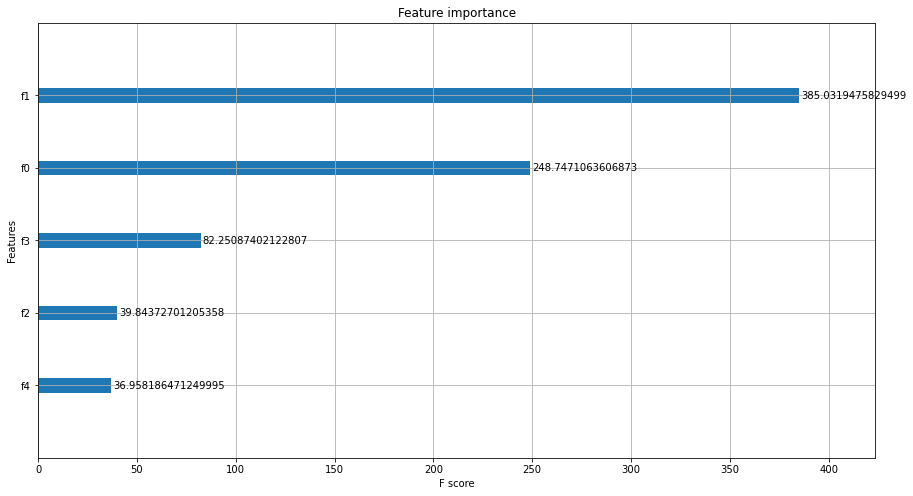

In [12]:
#-- 2.2 --  画图 重要度 （选择 weight、gain、cover）

# 特征重要性 f0纬度 f1经度 f2温度 f3风速 f4压力 f5降水
print(bst.get_score(importance_type='gain'))#增益
print(bst.get_score(importance_type='weight'))#分裂使用次数
print(bst.get_score(importance_type='cover'))#覆盖
fig,ax = plt.subplots(figsize=(15,8))#设置画布大小
plot_importance(bst, ax=ax, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', fmap='', importance_type='gain', max_num_features=None, grid=True)

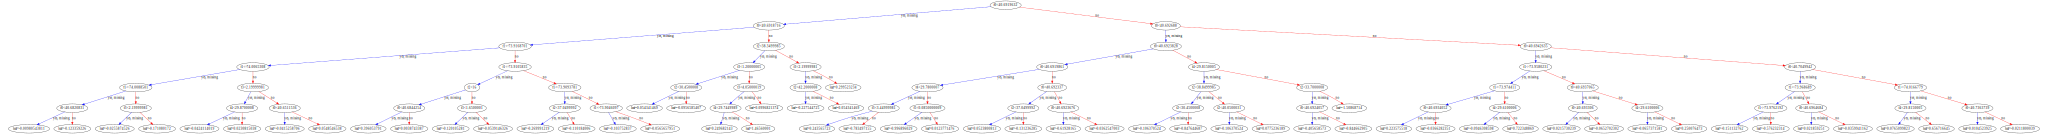

In [13]:
# #-- 2.3 --  决策树模型 子树的树状图表示 num_trees = 0，1，2，3，4，5，6
xgb.to_graphviz(bst, num_trees=6)

In [13]:
# #-- 2.4 --  决策树模型 表格表示
bst.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,f0,40.766670,0-1,0-2,0-1,732.270996,30400.0
1,0,1,0-1,f0,40.736374,0-3,0-4,0-3,3661.614750,18340.0
2,0,2,0-2,f1,-73.968132,0-5,0-6,0-5,3395.182620,12060.0
3,0,3,0-3,f0,40.720516,0-7,0-8,0-7,1039.527950,13440.0
4,0,4,0-4,f1,-73.987793,0-9,0-10,0-9,2732.133790,4900.0
...,...,...,...,...,...,...,...,...,...,...
929,7,118,7-118,Leaf,NaN,NaN,NaN,NaN,0.064980,80.0
930,7,119,7-119,Leaf,NaN,NaN,NaN,NaN,-0.152388,260.0
931,7,120,7-120,Leaf,NaN,NaN,NaN,NaN,-0.027302,1200.0
932,7,121,7-121,Leaf,NaN,NaN,NaN,NaN,0.086831,380.0


In [14]:
##### 3.计算距离矩阵 并 据此聚类

#-- 3.1 -- 获得 每个子树 的贡献度 占比 contrib1
def trees_contrib(y,evals_result):
    y = np.sort(y)
    IQR_4 = (y[int(len(y)*3/4)] - y[int(len(y)/4)])*3 #四分位距的4倍  即上下边缘距离
    contrib = []
    for i in range(len(evals_result)):
        if i == 0:
            contrib.append(IQR_4-evals_result[0])
        else:
            contrib.append(evals_result[i-1]-evals_result[i])
    contrib1 = [x/sum(contrib) for x in contrib] 
    return contrib1

evals_result = {}#收集每次迭代的根均方误差rmse
bst = xgb.train(params,dtrain,num_boost_round =num_trees,evals=[(dtrain,'train')],evals_result = evals_result)
evals_result = evals_result['train']['rmse']
contrib1 = trees_contrib(dataset[:,-1],evals_result)
del evals_result

[0]	train-rmse:2.26460
[1]	train-rmse:2.17711
[2]	train-rmse:2.11578
[3]	train-rmse:2.06921
[4]	train-rmse:2.03321
[5]	train-rmse:2.01795
[6]	train-rmse:2.00195
[7]	train-rmse:1.97428


In [15]:
#-- 3.2 -- 计算距离矩阵 and 层级聚类

def dist_dict(S,contrib1):
    # 构建 距离 得空矩阵
    dist = {}
    for i in range(len(S)):
        for j in range(i+1,len(S)):
            dist[str(i)+'-'+str(j)] = 0
    # 按权重得出相似度矩阵
    for k in range(len(contrib1)):
        for i in range(len(S)):
            for j in range(i+1,len(S)):
                if S[k][i] == S[k][j]:
                    dist[str(i)+'-'+str(j)] += contrib1[k]    
    # 相似度矩阵 to 距离矩阵
    for i in range(len(S)):
        for j in range(i+1,len(S)):
            dist[str(i)+'-'+str(j)] = 1-dist[str(i)+'-'+str(j)]
    return dist
#----------------------------------------------------------------调用函数
dtest = xgb.DMatrix(test[:,:-1],label = test[:,-1])  
S = pd.DataFrame(bst.predict(dtest,pred_leaf=True))
dist = dist_dict(S,contrib1)
array_dist = np.array(list(dist.values()))

#层级聚类
import scipy.cluster.hierarchy as sch
Z = sch.linkage(array_dist,method = 'average')
cluster = sch.fcluster(Z,t=0.25,criterion = 'distance') #criterion='maxclust',
#P=sch.dendrogram(Z)# 画图
#pd.DataFrame(cluster).to_csv('C:/Users/83621/citibike1/cluster_'+str(hour)+'h_before_split.csv')#存储 分裂前 聚类结果
del S,dist,array_dist,Z

In [16]:
#-- 3.3 -- 地理二次分割 

#数据准备
temp = pd.DataFrame(test)
temp['assis']=temp.index
cluster_ids = list(set(cluster))
max_value = max(cluster)
# 地理分割
for cluster_id in cluster_ids:
    loc = [i for i,v in enumerate(cluster) if v==cluster_id]
    if len(loc)>2:
        data_Array = (temp[temp['assis'].isin(loc)][[0,1]]).values
        temp1,n1 = 0,1
        for n in range(2,min(len(data_Array),7)):    #遍历不同k值下轮廓系数
            if Silhouette_ALL(data_Array,n)> temp1:
                temp1,n1 = Silhouette_ALL(data_Array,n),n
        if temp1>0.5:
            estimator = skc.KMeans(n_clusters = n1)#构造聚类器
            estimator.fit(data_Array)#聚类
            lable = list(estimator.labels_)
            new_clus_id = [i+1+max_value for i in lable]# 新的分类id
            max_value = max(new_clus_id )
            for i in range(len(loc)):
                cluster[loc[i]] = new_clus_id[i]

#大点集分解
cluster_ids = list(set(cluster))
for cluster_id in cluster_ids:
    loc = [i for i,v in enumerate(cluster) if v==cluster_id]
    if len(loc)>20:
        data_Array = (temp[temp['assis'].isin(loc)][[0,1]]).values
        estimator = skc.KMeans(n_clusters = int(len(loc)/10))#构造聚类器
        estimator.fit(data_Array)#聚类
        lable = list(estimator.labels_)
        new_clus_id = [i+1+max_value for i in lable]# 新的分类id
        max_value = max(new_clus_id )
        for i in range(len(loc)):
            cluster[loc[i]] = new_clus_id[i]
del data_Array,new_clus_id
#pd.DataFrame(cluster,index = station_list).to_csv('C:/Users/83621/citibike1/cluster_'+str(hour)+'h_after_split.csv')#存储 分裂后 聚类结果

In [18]:
##### 4.聚类结果 画图 可视化

from PIL import Image, ImageDraw 
from PIL import ImagePath  
#cluster = list(pd.read_csv('C:/Users/83621/citibike1/cluster_'+str(hour)+'h_after_split.csv',index_col=0)['0'])#读取聚类结果
    
def plot_path(xy):# 找到合理的画图路径
    temp1 = pd.DataFrame(np.array(xy),columns=['lon','lat'])
    lat_bar = np.mean(temp1['lat'])
    temp2 = temp1[temp1['lat']>=lat_bar]
    temp3 = temp1[temp1['lat']< lat_bar]
    temp2 = temp2.sort_values(by='lon',ascending=True)
    temp3 = temp3.sort_values(by='lon',ascending=False)
    temp1 = pd.concat([temp2,temp3])
    return [(temp1['lon'][x],temp1['lat'][x]) for x in temp1.index]
#-----------------------------------------------------------------------------调用---------------------------------------------
im = Image.new('RGB',(800,1000),'white')
draw = ImageDraw.Draw(im)
cluster_result = pd.DataFrame(test)[[0,1]]
cluster_result['class'] = cluster
cluster_result.columns = ['lat','lon','class']
cluster_result['lat_plot'] = (max(cluster_result['lat'])-cluster_result['lat'] )*3600
cluster_result['lon_plot'] = (cluster_result['lon']-min(cluster_result['lon'])  )*3600

#for i in cluster_result.index:
    #draw.polygon(((int(cluster_result['lon_plot'][i])-2,int(cluster_result['lat_plot'][i])+2),(int(cluster_result['lon_plot'][i])+2,int(cluster_result['lat_plot'][i])+2),(int(cluster_result['lon_plot'][i])+2,int(cluster_result['lat_plot'][i])-2),(int(cluster_result['lon_plot'][i])-2,int(cluster_result['lat_plot'][i])-2)),fill='red')
    
for cluster_i in set(cluster_result['class']):
    temp = cluster_result[cluster_result['class'] == cluster_i]
    if len(temp)>3:        
        xy = [(temp['lon_plot'][i],temp['lat_plot'][i]) for i in temp.index if is_convex(temp,i)] 
        xy = plot_path(xy)
        draw.polygon(xy, fill ="brown")  
    elif  len(temp) == 3:
        draw.polygon(((int(temp['lon_plot'][temp.index[0]]),int(temp['lat_plot'][temp.index[0]])),(int(temp['lon_plot'][temp.index[1]]),int(temp['lat_plot'][temp.index[1]])),(int(temp['lon_plot'][temp.index[2]]),int(temp['lat_plot'][temp.index[2]]))),fill='brown')#,outline='black')
    elif  len(temp) == 2:
        draw.polygon(((temp['lon_plot'][temp.index[0]]-7,temp['lat_plot'][temp.index[0]]+7),(temp['lon_plot'][temp.index[0]]+7,temp['lat_plot'][temp.index[0]]+7),(temp['lon_plot'][temp.index[1]]+7,temp['lat_plot'][temp.index[1]]-7),(temp['lon_plot'][temp.index[1]]-7,temp['lat_plot'][temp.index[1]]+7)),fill='brown')
    else:
        draw.polygon(((temp['lon_plot'][temp.index[0]]-2,temp['lat_plot'][temp.index[0]]+2),(temp['lon_plot'][temp.index[0]]+2,temp['lat_plot'][temp.index[0]]+2),(temp['lon_plot'][temp.index[0]]+2,temp['lat_plot'][temp.index[0]]-2),(temp['lon_plot'][temp.index[0]]-2,temp['lat_plot'][temp.index[0]]-2)),fill='brown')

im.show()

In [23]:
import folium

def plot_path(xy):# 找到合理的画图路径
    temp1 = pd.DataFrame(np.array(xy),columns=['lon','lat'])
    lat_bar = np.mean(temp1['lat'])
    temp2 = temp1[temp1['lat']>=lat_bar]
    temp3 = temp1[temp1['lat']< lat_bar]
    temp2 = temp2.sort_values(by='lon',ascending=True)
    temp3 = temp3.sort_values(by='lon',ascending=False)
    temp1 = pd.concat([temp2,temp3])
    return [(temp1['lon'][x],temp1['lat'][x]) for x in temp1.index]
#-----------------------------------------------------------------------------调用---------------------------------------------
im = folium.Map(location=[40.655400,-73.976431],tiles='Stamen Terrain',zoom_start=11)
cluster_result = pd.DataFrame(test)[[0,1]]
cluster_result['class'] = cluster
cluster_result.columns = ['lat_plot','lon_plot','class']
for cluster_i in set(cluster_result['class']):
    temp = cluster_result[cluster_result['class'] == cluster_i]
    if len(temp)>3:  
        xy = [[temp['lat_plot'][i],temp['lon_plot'][i]] for i in temp.index if is_convex(temp,i)] 
        xy = plot_path(xy)
        folium.Polygon(locations=xy,popup=folium.Popup('标记坐标点之间多边形区域', max_width=200),color='brown', # 线颜色
                       fill=True, # 是否填充
                       weight=2, # 边界线宽
                       fill_opacity=0.9,#设置透明度
                      ).add_to(im)       
im 

In [24]:
im.save(os.path.join(r'C:\Users\83621\Desktop', 'figure3.html'))

In [451]:
##### 5. 第一个cluster 的8 个站点

temp = pd.read_csv("C:/Users/83621/citibike1/ori_data/202201-citibike-tripdata.csv")
stations = [7727.08,7713.11,7692.11,7713.01,7680.03,7646.04,7650.05,7634.01]
lat=[40.80863218,40.8082,40.806758,40.805973,40.804213,40.802692,40.802117,40.800836]
lon=[-73.9595861,-73.9641,-73.960708,-73.964928,-73.966991,-73.96295,-73.96818,-73.966449]
temp1 = temp[(temp['start_station_id']).isin(stations)]
temp2 = temp[(temp['end_station_id']).isin(stations)]

nyc_map = folium.Map(location=[40.655400,-73.976431],zoom_start=11)
for i in range(8):
    folium.CircleMarker(location = [lat[i],lon[i]],radius = 10, fill = True,color = 'red').add_to(nyc_map)        
del temp,temp1,temp2
nyc_map